# Beer Styles Predictions

Data comes from Kaggle Dataset: https://www.kaggle.com/jtrofe/beer-recipes

## Import Necessary Libaries

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Clean Data

In [70]:
#import data into dataframe
rec = pd.read_csv('./BeerRecipes/recipeData.csv', encoding = "ISO-8859-1")

In [71]:
#there are 22 columns and 73K rows
rec.shape

(73861, 22)

In [72]:
#quickly view which columns contain nulls, these are not easily imputable, and there is lots of missind data, will drop
rec.isnull().sum()

BeerID               0
Name                 1
URL                  0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
dtype: int64

In [73]:
#drop columns with lots of missing data
rec.drop(columns = ['MashThickness', 'PitchRate', 'PrimaryTemp', 'PrimingMethod', 'PrimingAmount', 'BoilGravity'], inplace = True)

In [74]:
#drop columns that won't be used in prediction, non-recipe specific columns
rec.drop(columns = ['Name', 'BeerID', 'Size(L)', 'BoilSize', 'BrewMethod', 'URL', 'SugarScale'], inplace = True)

In [75]:
#drop rows that do not have a style, this is our y(what we will predict)
rec.drop(rec[rec['Style'].isnull()].index, inplace =  True)


#### Definining Broad Categories of Beer Styles

In [76]:
#one hot encoding styles
rec['IPA'] = rec['Style'].apply(lambda x: 1 if x.find('IPA') > -1 else 0)
rec['Porter'] = rec['Style'].apply(lambda x: 1 if x.find('Porter') > -1 else 0)
rec['Stout'] = rec['Style'].apply(lambda x: 1 if x.find('Stout') > -1 else 0)
rec['Ale'] = rec['Style'].apply(lambda x: 1 if x.find('Ale') > -1 else 0)
rec['Lager'] = rec['Style'].apply(lambda x: 1 if x.find('Lager') > -1 else (1 if x.find('Pils') > -1 else 0))
rec['Witbier'] = rec['Style'].apply(lambda x: 1 if x.find('Witbier') > -1 else 0)
rec['Saison'] = rec['Style'].apply(lambda x: 1 if x.find('Saison') > -1 else 0)


In [77]:
#defined styles present in dataset
rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']].sum().sum()

53592

In [78]:
#drop styles that don't fit into pre-defined categories
rec.drop(rec[(rec['IPA'] != 1) & (rec['Porter'] != 1) & (rec['Stout'] != 1) & (rec['Ale'] != 1) & (rec['Lager'] != 1) \
                      & (rec['Witbier'] != 1) & (rec['Saison'] != 1)].index, inplace = True)

In [79]:
#reset the index 
rec.reset_index(drop = True, inplace = True)

In [80]:
#setting column of ids for newly declared styles, reverse one-hot-encoded
rec['New_StyleID'] = 0

for i in range(rec.shape[0]):
    if rec.loc[i, 'IPA'] == 1:
        rec.loc[i, 'New_StyleID'] = 'IPA'
    elif rec.loc[i, 'Porter'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Porter'
    elif rec.loc[i, 'Stout'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Stout'
    elif rec.loc[i, 'Ale'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Ale'
    elif rec.loc[i, 'Lager'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Lager'
    elif rec.loc[i, 'Witbier'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Witbier'
    elif rec.loc[i, 'Saison'] == 1:
        rec.loc[i, 'New_StyleID'] = 'Saison'

In [81]:
rec.head()

,Style,StyleID,OG,FG,ABV,IBU,Color,BoilTime,Efficiency,IPA,Porter,Stout,Ale,Lager,Witbier,Saison,New_StyleID
0,Cream Ale,45,1.055,1.013,5.48,17.65,4.83,75,70.0,0,0,0,1,0,0,0,Ale
1,American IPA,7,1.063,1.018,5.91,59.25,8.98,60,70.0,1,0,0,0,0,0,0,IPA
2,American IPA,7,1.061,1.017,5.80,54.48,8.50,60,70.0,1,0,0,0,0,0,0,IPA
3,Belgian Blond Ale,20,1.060,1.010,6.48,17.84,4.57,90,72.0,0,0,0,1,0,0,0,Ale
4,American Pale Ale,10,1.055,1.013,5.58,40.12,8.00,70,79.0,0,0,0,1,0,0,0,Ale


#### EDA

In [82]:
#saving count of top style, American IPA, to determine baseline accuracy
top_style = rec.groupby(by = 'Style')[['Style']].count().sort_values(by = 'Style', ascending = False).rename(columns = {'Style':'Style Count'}).reset_index().loc[0,'Style Count']

#showing counts of granular styles in dataset
rec.groupby(by = 'Style')[['Style']].count().sort_values(by = 'Style', ascending = False).rename(columns = {'Style':'Style Count'}).reset_index().tail()

,Style,Style Count
63,Czech Amber Lager,32
64,Tropical Stout,31
65,Pre-Prohibition Lager,30
66,Pre-Prohibition Porter,12
67,London Brown Ale,8


In [83]:
#dataframe showing totals of styles
style_agg = pd.DataFrame(rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']].sum(), columns = ['Style Count']).reset_index().rename(columns = {'index':'Style'}).sort_values(by = 'Style Count', ascending = False)
style_agg['percent'] = style_agg['Style Count'].apply(lambda x: x/style_agg['Style Count'].sum()*100)
style_agg

,Style,Style Count,percent
3,Ale,18859,35.189954
0,IPA,17064,31.840573
2,Stout,5954,11.109867
4,Lager,5326,9.938050
1,Porter,2700,5.038065
6,Saison,2617,4.883192
5,Witbier,1072,2.000299


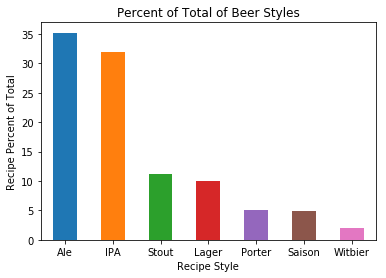

In [84]:
#plotting counts of styles
style_agg.plot(x = 'Style', y = 'percent', kind = 'bar', legend = False)
plt.title('Percent of Total of Beer Styles')
plt.xlabel('Recipe Style')
plt.ylabel('Recipe Percent of Total')
plt.xticks(rotation = 0);

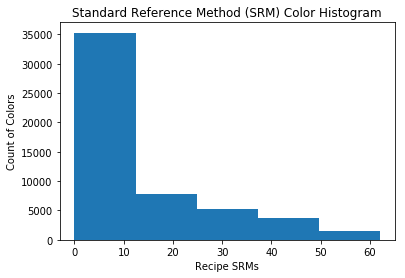

In [85]:
#histogram of color
rec.hist(column = 'Color', grid = False, bins = 15)
plt.xlim(-3, 65)
plt.title('Standard Reference Method (SRM) Color Histogram')
plt.xlabel('Recipe SRMs')
plt.ylabel('Count of Colors');

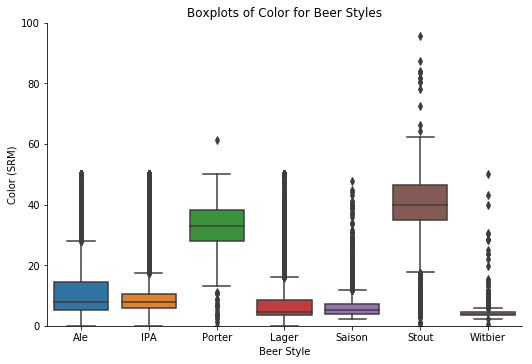

In [86]:
#boxplots of Color of beer styles
sns.factorplot(kind = 'box', 
               y = 'Color',
               x = 'New_StyleID',
               data = rec,
               size = 5,
               aspect = 1.5)
plt.title('Boxplots of Color for Beer Styles')
plt.xlabel('Beer Style')
plt.ylabel('Color (SRM)')
plt.ylim([0,100]);

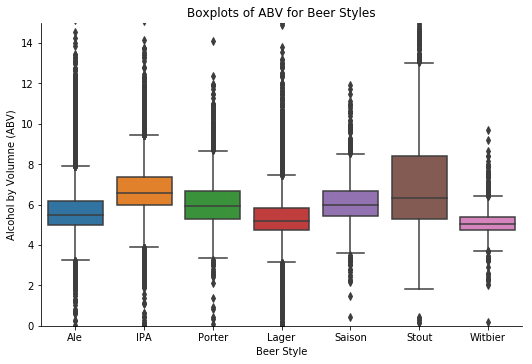

In [87]:
#boxplot of ABV of beer styles
sns.factorplot(kind = 'box', 
               y = 'ABV',
               x = 'New_StyleID',
               data = rec,
               size = 5,
               aspect = 1.5)
plt.title('Boxplots of ABV for Beer Styles')
plt.xlabel('Beer Style')
plt.ylabel('Alcohol by Volumne (ABV)')
plt.ylim([0,15]);

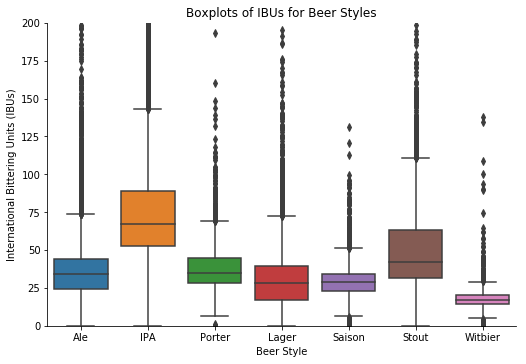

In [88]:
#boxplot of IBUs of beer styles
sns.factorplot(kind = 'box', 
               y = 'IBU',
               x = 'New_StyleID',
               data = rec,
               size = 5,
               aspect = 1.5)
plt.title('Boxplots of IBUs for Beer Styles')
plt.xlabel('Beer Style')
plt.ylabel('International Bittering Units (IBUs)')
plt.ylim([0,200]);

## Split/prepare data for modeling

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [90]:
#declare X and y
X = rec[['OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency']]
y = rec[['IPA', 'Porter', 'Stout', 'Ale', 'Lager', 'Witbier', 'Saison']]

In [91]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#set as numpy array
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

In [92]:
#standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Create Models

### A) CART

In [93]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [94]:
def CART_model_picker(model_list, X_train, y_train, X_test, y_test):
    '''Returns cross-val score and score for all input CART models, returns in sorted order of best performing'''
    results = []
    
    for (k,v) in model_list.items():
        scores = cross_val_score(v, X_train, y_train, cv = 5, n_jobs = -1)
        v.fit(X_train, y_train)

        results.append((k, scores.mean(), v.score(X_test, y_test)))
    
    results.sort(key = lambda x: x[2], reverse = True)
    results.insert(0, ('Model', 'Cross_val_score mean', 'Model Score R^2'))
    
    return results

In [95]:
#figure out which CART model performs the best
models = {'Decision Tree': DecisionTreeClassifier(),
          'Extra Trees': ExtraTreesClassifier(),
          'Random Forest':RandomForestClassifier()
         }

dt_results = CART_model_picker(models, X_train, y_train, X_test, y_test)
dt_results

[('Model', 'Cross_val_score mean', 'Model Score R^2'),
 ('Decision Tree', 0.5598441615089501, 0.5689762408259734),
 ('Random Forest', 0.5337475105043737, 0.5378778455031721),
 ('Extra Trees', 0.5099963462584396, 0.5151138201268814)]

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


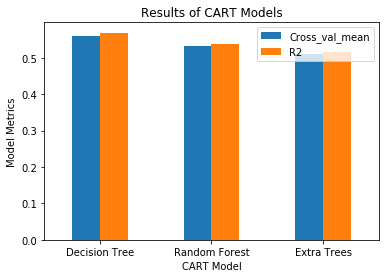

In [96]:
#plotting results from model picker
cart_res = pd.DataFrame(dt_results[1:], columns = ['Model', 'Cross_val_mean', 'R2']).sort_values(by = 'R2', ascending = False)
cart_res.plot(x = 'Model', y = ['Cross_val_mean', 'R2'], kind = 'bar')
plt.title('Results of CART Models')
plt.xlabel('CART Model')
plt.ylabel('Model Metrics')
plt.xticks(rotation=0);

In [97]:
#dataframe of feature importances
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_feats = pd.DataFrame(list(zip(['OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency'], dtc.feature_importances_)), \
                         columns = ['Feature', 'Importance']).sort_values(by = 'Importance', ascending = False)


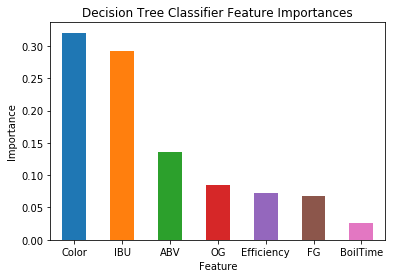

In [98]:
#plotting feature importances for top decision tree classifier
dtc_feats.plot(x = 'Feature', y = 'Importance', kind = 'bar', legend = False)
plt.title('Decision Tree Classifier Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=0);

### B) Neural Network

In [99]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [190]:
#create model
model = Sequential()

In [191]:
#network topology
input_units = X_train.shape[1]
hidden_units = 4

#input layer
model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu',
                kernel_regularizer=regularizers.l2(0.0001)))
#hidden layer
model.add(Dense(50, activation = 'relu',))
#hidden layer
model.add(Dense(50, activation = 'relu',))



#output layer
model.add(Dense(7, activation = 'softmax'))

In [192]:
#compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [193]:
#train the model
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 30, 
                   batch_size = None, 
                   verbose = 1)

Train on 37514 samples, validate on 16078 samples
Epoch 1/30
37514/37514 [==============================] - 5s 137us/step - loss: 1.1393 - acc: 0.5942 - val_loss: 1.0301 - val_acc: 0.6190
Epoch 2/30
37514/37514 [==============================] - 5s 126us/step - loss: 1.0022 - acc: 0.6284 - val_loss: 0.9797 - val_acc: 0.6365
Epoch 3/30
37514/37514 [==============================] - 5s 121us/step - loss: 0.9770 - acc: 0.6319 - val_loss: 0.9656 - val_acc: 0.6372
Epoch 4/30
37514/37514 [==============================] - 5s 123us/step - loss: 0.9626 - acc: 0.6348 - val_loss: 0.9534 - val_acc: 0.6427
Epoch 5/30
37514/37514 [==============================] - 5s 124us/step - loss: 0.9488 - acc: 0.6396 - val_loss: 0.9432 - val_acc: 0.6409
Epoch 6/30
37514/37514 [==============================] - 5s 129us/step - loss: 0.9356 - acc: 0.6458 - val_loss: 0.9310 - val_acc: 0.6503
Epoch 7/30
37514/37514 [==============================] - 4s 102us/step - loss: 0.9280 - acc: 0.6493 - val_loss: 0.9276 - 

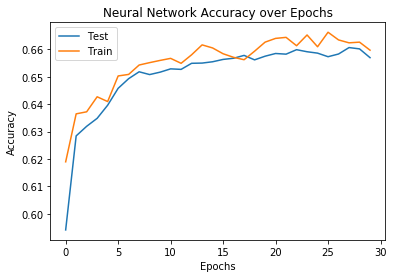

In [194]:
#plotting accuracy over epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Neural Network Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Test', 'Train']);

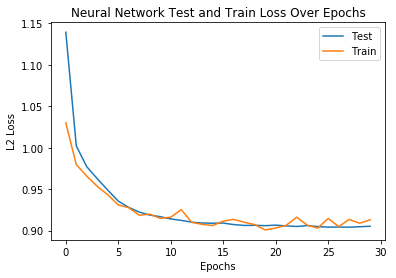

In [195]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend();
plt.title('Neural Network Test and Train Loss Over Epochs')
plt.ylabel('L2 Loss')
plt.xlabel('Epochs')
plt.legend(['Test', 'Train']);